# Homework 2 (excercise 2 and Bonus)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 5)
import numpy as np
import sys
from bs4 import BeautifulSoup as BSoup
import requests
import pandas as pd
import scipy.stats as stats


## Assumptions
**As the data has many missing values, especially for the field of their master projects, we are going to make some assumptions.**

### 1) The students finally will graduate:
** This is based on our intuition, unlike the bachelor students, usually most of the master students tend to graduate**.
**So if the master project data is missing and 2 semesters past from the last taken semester (minimum 2 semesters already taken), we are going to add a master project to them (note that master student in Informatique need to take master project in order to graduate)**
#### Exception: we can not make this assumption for the students which are studying in 2015-2016.


### 2) The students whose first record is 'semester  2' or 'semester 3' in year 2007  has begun their study before 2007:
**Although master students can begin their studies by semester 2, so as we do not have enough information we are going to discard them**

### 3) The students who are taking their master semester (not project) in 2016-2017 cannot finish their studies by the end of the year.
**This assumption yields that we only keep the master project data for 2016-2017**
### 4) If there is two consecutive 'semester 2' in the records we add a 'semester 3' in between.
**This is based on the EPFL regulation that after semester 2 there is semester 3.**

### 5) The students whose Mineur field is not empty takes longer time to finish their results.
**Since there are students who are doing mineur it is not 'fair' to analyze their time to finish with others. SO, after general analysis investigate minor students seperately.**


In [2]:
r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270')
soup = BSoup(r.text.encode('utf-8'),'lxml')
links = soup.find_all("select")

# The following code stores the values which are going to 
#be used in request.get for data

value_years = {} # Initilizing the datas
years = []
value_semesters = {}
semester = []
value_typeSemester = {}
value_typeSemester["Semestre d'automne"] = []
value_typeSemester['Semestre de printemps'] = []
typeSemester = []
typeSemester.append("Semestre d'automne")
typeSemester.append('Semestre de printemps')

for i in range(2007,2017):
    value_years[str(i)] = []
    years.append(str(i))
for i in range(1,4):
    value_semesters['Master semestre '+str(i)] = []
    semester.append('Master semestre '+str(i))
value_semesters['Projet Master automne'] = []
value_semesters['Projet Master printemps'] = []
semester.append('Projet Master automne')
semester.append('Projet Master printemps')
value_informatique = '249847'
for link in links:                     
    namesAll = link.find_all("option")
    for names in namesAll:
        #print(names.contents)
        if names.contents:
            if names.contents[0][:4] in years: # stores the values for years
                value_years[str(names.contents[0][:4])] = names['value']
            elif names.contents[0] in semester: # stores the values for semesters
                value_semesters[names.contents[0]] = names['value']
            elif names.contents[0] in typeSemester: # stores the values for type of semesters
                value_typeSemester[names.contents[0]] = names['value']

In [3]:
# The following code get the data for a special year and field and semester 
def get_data3(query):
    r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?ww_x_GPS=-1&ww_i_reportmodel=133685247&ww_i_reportModelXsl=133685270',params=query)
    soup = BSoup(r.text.encode('utf-8'),'lxml')
    table_soup = soup.find('table')
    #data inside the cells of table
    data_cell = table_soup.find_all('td')#.renderContents()#.strip()
    d=[]
    st = []
    h = []
    for entry in data_cell:
        s = entry.text
        s = s.replace(u'\xa0', u' ')
        s = s.replace(u'Ã©',u'e') 
        d.append(s)
    #headers
    headers=soup.findAll('th')
    for header in headers[1:]:
        temp = header.text
        temp = temp.replace(u'Ã©',u'e')
        h.append(temp)
        
    #for getting current semester info
    headers=soup.findAll('th')
    #creating dataframe with the obtained data
    st=[d[x:x+11] for x in range(0,len(d),12)]
    dfr=pd.DataFrame(st,columns=h)
    return dfr
    

In [4]:
# In this cell we want to import whole data into a pandas dataframe
# where we pass the paramters found in the previouse cell
#data = pd.DataFrame({'field':[],'gender':[],'name':[],'status':[],'sciper':[],'gender':[]
 #                    ,'year':[],'semester':[],'type semester':[]})
data = pd.DataFrame()
for y in years: # concatenating whole data into a pandas dataframe
    for tS in typeSemester:
        for vS in semester:
            #print(y,vS,tS)
            query = {'ww_x_UNITE_ACAD' : value_informatique,'ww_x_PERIODE_ACAD':value_years[str(y)],
        'ww_x_PERIODE_PEDAGO':value_semesters[vS],
         'ww_x_HIVERETE':value_typeSemester[tS]}
            data_recieved = get_data3(query)
            #data_recieved['field'] = field
            data_recieved['year'] = y
            data_recieved['semester'] = vS
            data_recieved['type semester'] = tS     
            data = pd.concat([data,data_recieved])
data.head()

,Civilite,Ecole Echange,FiliÃ¨re opt.,Mineur,No Sciper,Nom Prenom,Orientation Bachelor,Orientation Master,Specialisation,Statut,Type Echange,semester,type semester,year
0,Monsieur,,,,153066,Aeberhard FranÃ§ois-Xavier,,,,Present,,Master semestre 1,Semestre d'automne,2007
1,Madame,,,,180027,Agarwal Megha,,,,Present,,Master semestre 1,Semestre d'automne,2007
2,Monsieur,,,,152232,Anagnostaras David,,,,Present,,Master semestre 1,Semestre d'automne,2007
3,Monsieur,,,,177395,Auroux Damien,,,,Present,,Master semestre 1,Semestre d'automne,2007
4,Monsieur,,,,161970,Awalebo Joseph,,,,Present,,Master semestre 1,Semestre d'automne,2007


In [5]:
mineurs = data[data['Mineur']!=''] # find the students who have mineur
unique_mineurs = pd.Series.unique(mineurs['No Sciper']) # getting their Sciper #
unique_data = pd.Series.unique(data['No Sciper'])

In [6]:
def duration(person): # The following code calculates the passed time for each student
    semester = data.loc[data['No Sciper']==person]['semester'] # The taken semesters
    years_semester = data.loc[data['No Sciper']==person]['year'] # The taken semesters' years
    # The following command is related to the Assumption 2
    if semester.iloc[0] != 'Master semestre 1': 
        if years_semester.iloc[0] == '2007':
            return -1
    # The following command is related to the Assumption 3
    if semester.iloc[-1] != 'Projet Master automne' and semester.iloc[-1] != 'Projet Master printemps':
        if years_semester.iloc[0] == '2016':
            return -1
    current_sem = semester.iloc[0]
    appended_sem = []
    # The following code is related to assumption 4
    for sem in semester.iloc[1:]:
        if sem == current_sem and sem=='Master semestre 2':
            appended_sem.append(current_sem)
        current_sem = sem
    # The following code is related to assumption 1    
    if semester.iloc[-1] != 'Projet Master automne' and semester.iloc[-1] != 'Projet Master printemps': 
        semester = semester.append(pd.Series('master'))
    length_study = len(semester) + len(appended_sem)
    return length_study*6

In [7]:
Male = []
Female = []
Male_mineurs = []
Female_mineurs = []
for person in unique_data:
    gen = data.loc[data['No Sciper']==person]['Civilite']
    # check if the students has mineur or not (check Assumption 5)
    if person in unique_mineurs:
        length_study = duration(person)
        if length_study != -1:
            # adding the duration based on the gender
            if gen.iloc[0] == 'Monsieur':
                Male_mineurs.append(length_study)
            else:
                Female_mineurs.append(length_study)
    else:
        length_study = duration(person)
        if length_study != -1:
            if gen.iloc[0] == 'Monsieur':
                Male.append(length_study)
            else:
                Female.append(length_study)

        

In [8]:
Whole_data = np.concatenate([Male,Female])
print(np.mean(Whole_data))
print(np.std(Whole_data))

24.7616361072
6.04038086467


# The average time of studies for the master student is 24.76 months with standard deviation of 6.04

### Finding the average stay for each specialisation

In [9]:
special = data[data['Specialisation']!='']
# Extracting the specializations from the data
special_categories = pd.Series.unique(special['Specialisation'])
unique_special = pd.Series.unique(special['No Sciper'])

In [10]:
duration_categori = {}
for categori in special_categories:
    duration_categori[categori] = []
    counts = []
    categori_special = special[special['Specialisation'] == categori]
    unique_sciper = pd.Series.unique(categori_special['No Sciper'])
    for student in unique_sciper:
        length_study = duration(student)
        if length_study != -1:
            counts.append(length_study)
    duration_categori[categori] = np.mean(counts)
    

In [11]:
duration_categori

{'Biocomputing': 30.0,
 'Computer Engineering - SP': 27.600000000000001,
 'Computer Science Theory': 24.0,
 'Data Analytics': 23.0,
 'Foundations of Software': 29.225806451612904,
 'Information Security - SP': 25.714285714285715,
 'Internet Information Systems': 24.0,
 'Internet computing': 28.531914893617021,
 'Service science': 27.600000000000001,
 'Signals, Images and Interfaces': 30.375,
 'Software Systems': 26.117647058823529}

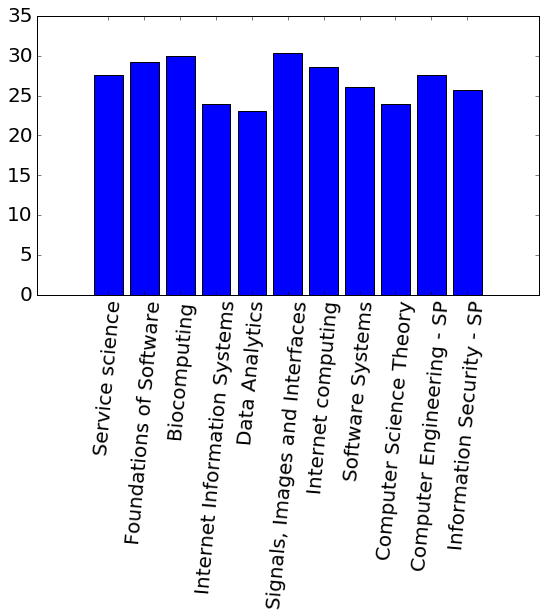

In [12]:
plt.bar(range(len(duration_categori)), duration_categori.values(), align='center')
plt.xticks(range(len(duration_categori)), duration_categori.keys(),rotation=85,fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=18)

### In order to show difference in average is statistically significan for specific specialization, we are going to use the T-student test again. However, this time we are going to use One-Sample T-Test. The reason is for general distribution we have enough data, so we  can just check if a sample mean differs from the population mean.

In [13]:
statistics = []
for categori in special_categories:
    duration_categori[categori] = []
    counts = []
    categori_special = special[special['Specialisation'] == categori]
    unique_sciper = pd.Series.unique(categori_special['No Sciper'])
    for student in unique_sciper:
        length_study = duration(student)
        if length_study != -1:
            counts.append(length_study)
    statistics.append(stats.ttest_1samp(a= counts,               # Sample data
                 popmean= 24.7616361072))  # Pop mean
    duration_categori[categori] = np.mean(counts)
    

/Users/salehi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
statistics

[Ttest_1sampResult(statistic=6.3587100407372237, pvalue=7.5080181516131099e-09),
 Ttest_1sampResult(statistic=6.2870156367834502, pvalue=3.829242358218992e-08),
 Ttest_1sampResult(statistic=1.5121854018106478, pvalue=0.2276792301514903),
 Ttest_1sampResult(statistic=4.0911813188090056, pvalue=0.00028333830093252906),
 Ttest_1sampResult(statistic=2.8060586473301679, pvalue=0.011273847627930701),
 Ttest_1sampResult(statistic=1.1826516220000003, pvalue=0.30244149997552422),
 Ttest_1sampResult(statistic=1.8916853112892975, pvalue=0.076775784690045659),
 Ttest_1sampResult(statistic=0.86090574803660247, pvalue=0.4223540235948065),
 Ttest_1sampResult(statistic=-1.7616361072000011, pvalue=0.13843121387942231),
 Ttest_1sampResult(statistic=nan, pvalue=nan),
 Ttest_1sampResult(statistic=nan, pvalue=nan)]

In [15]:
duration_categori

{'Biocomputing': 30.0,
 'Computer Engineering - SP': 27.600000000000001,
 'Computer Science Theory': 24.0,
 'Data Analytics': 23.0,
 'Foundations of Software': 29.225806451612904,
 'Information Security - SP': 25.714285714285715,
 'Internet Information Systems': 24.0,
 'Internet computing': 28.531914893617021,
 'Service science': 27.600000000000001,
 'Signals, Images and Interfaces': 30.375,
 'Software Systems': 26.117647058823529}

### We choose the confidence level to be 95%. As it can be seen Biocomputing and Computer Engineering are significantly different than population. Furthermore, according to the chosen confidence level Data Analytics and Foundations of Software.

# Bonus:  The duration that takes for male and female to finish the master is not significantly different

### Similar to the excercise 1 we use Two-Sample T-Test, as it is seen the null hypothesis is accepted, which means with high probability the two genders are from same distribution.


In [16]:
stats.ttest_ind(a= Male,
                b= Female,
                equal_var=False)    # Assume samples have equal variance?

Ttest_indResult(statistic=0.43043287417696613, pvalue=0.66763496567037306)

### For this part we only consider students who have not mineure. We find the average time it takes to finish the master as a function of the starting year. More precisely, we gather the duration of studies for student who have started their study in 2007-2008, 2008-2009,..., 2015-21016 and we plot that as a function of starting year.

In [17]:
Male = {}
Female = {}
for i in range(2007,2016):
    Male[str(i)] = []
    Female[str(i)] = []
    
for person in unique_data:
    gen = data.loc[data['No Sciper']==person]['Civilite']
    year_person = data.loc[data['No Sciper']==person]['year']
    # check if the students has mineur or not (check Assumption 5)
    if person not in unique_mineurs:
        length_study = duration(person)
        if length_study != -1:
            # adding the duration based on the gender
            if gen.iloc[0] == 'Monsieur':
                Male[year_person.iloc[0]].append(length_study)
            else:
                Female[year_person.iloc[0]].append(length_study)


In [18]:
Male_duration = []
Female_duration = []
year = []
for i in range(2007,2016):
    year.append(i)
    Male_duration.append(np.mean(Male[str(i)]))
    Female_duration.append(np.mean(Female[str(i)]))
    

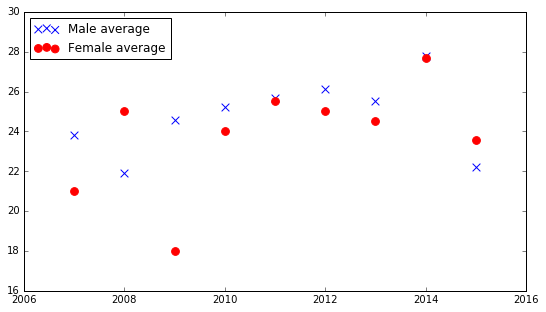

In [19]:
ma=plt.scatter(year,Male_duration,marker = 'x',color='b',s=60)
fe=plt.scatter(year,Female_duration,marker = 'o',color='r',s=60)
plt.legend((ma,fe),('Male average','Female average'),loc=2)

### The scatterplot follows our expectation, i.e., the two genders have same mean. As it can be seen sometimes men are males are more than female, and sometimes reverse.